epoch  200 | loss 0.1716 | acc 0.958
epoch  400 | loss 0.1010 | acc 0.975
epoch  600 | loss 0.0765 | acc 0.982
epoch  800 | loss 0.0628 | acc 0.992
epoch 1000 | loss 0.0541 | acc 0.993


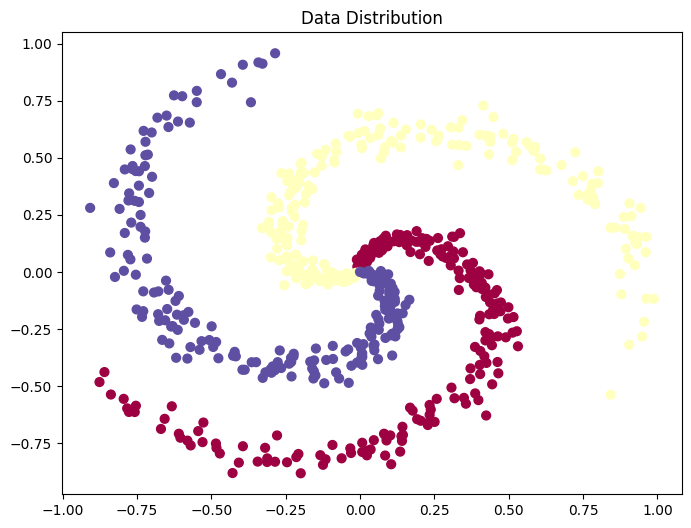

In [4]:
# Simple backpropagation implementation in Python
import numpy as np
import matplotlib.pyplot as plt

# --- helper functions ---
def relu(x):
    return np.maximum(0, x)

def relu_grad(z):
    return (z > 0).astype(float)

def softmax(z):
    z_shift = z - np.max(z, axis=1, keepdims=True) # for numerical stability
    exp_z = np.exp(z_shift)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def cross_entropy_loss(P, Y):
    eps = 1e-12
    return -np.mean(np.sum(Y * np.log(P + eps), axis=1)) # negative log likelihood

def one_hot(y, K):
    Y = np.zeros((y.size, K))
    Y[np.arange(y.size), y] = 1.0
    return Y

# --- data ---
def make_blobs(m_per_class=100, K=3, d=2, seed = 0):
    np.random.seed(seed)
    X = np.zeros((m_per_class*K, d))
    y = np.zeros(m_per_class*K, dtype='uint8')
    for j in range(K):
        ix = range(m_per_class*j, m_per_class*(j+1))
        r = np.linspace(0.0, 1, m_per_class) # radius
        t = np.linspace(j*4, (j+1)*4, m_per_class) + np.random.randn(m_per_class)*0.2 # theta
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    return X, y

# Model 
class SimpleNN:
    def __init__(self, d, h, K, seed=42):
        rng = np.random.default_rng(seed)

        self.W1 = rng.standard_normal((d, h)) * np.sqrt(2. / d) # He initialization
        self.b1 = np.zeros((1, h))
        self.W2 = rng.standard_normal((h, K)) * np.sqrt(2. / h)
        self.b2 = np.zeros((1, K))

    def forward(self, X):
        Z1 = X @ self.W1 + self.b1
        A1 = relu(Z1)
        Z2 = A1 @ self.W2 + self.b2
        P = softmax(Z2)
        cache = {"X": X, "Z1": Z1, "A1": A1, "Z2": Z2, "P": P}
        return P, cache
    
    def backward(self, cache, Y):
        X, Z1, A1, Z2, P = cache['X'], cache['Z1'], cache['A1'], cache['Z2'], cache['P']
        m = Y.shape[0]
        dZ2 = (P - Y) / m
        dW2 = A1.T @ dZ2
        db2 = np.sum(dZ2, axis=0, keepdims=True)
        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * relu_grad(Z1)
        dW1 = X.T @ dZ1
        db1 = np.sum(dZ1, axis=0, keepdims=True)
        grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
        return grads
    
    def step(self, grads, lr):
        self.W1 -= lr * grads['dW1']
        self.b1 -= lr * grads['db1']
        self.W2 -= lr * grads['dW2']
        self.b2 -= lr * grads['db2']

if __name__ == "__main__":
    X, y = make_blobs(m_per_class=200, K=3, d=2, seed = 1)
    K = 3
    Y = one_hot(y, K)

    net = SimpleNN(d=X.shape[1], h=32, K=K, seed=0)
    lr = 1.0
    epochs = 1000
    for epoch in range(1, epochs + 1):
        P, cache = net.forward(X)
        loss = cross_entropy_loss(P, Y)
        grads = net.backward(cache, Y)
        net.step(grads, lr=lr)

        if epoch % 200 == 0:
            pred = np.argmax(P, axis=1)
            acc = (pred == y).mean()
            print(f"epoch {epoch:4d} | loss {loss:.4f} | acc {acc:.3f}")


# Visualization
plt.figure(figsize=(8,6))
plt.scatter(X[:,0], X[:,1], c=y, s=40, cmap=plt.cm.Spectral)
plt.title("Data Distribution")
plt.show()


